# Nairobi House Price Prediction – Day 2  
Data Cleaning & Feature Engineering + Basic EDA

Goal: Make the raw data model-ready  
- Remove duplicates
- Handle missing values
- Standardize location names
- Convert size units
- Remove extreme outliers

New features:
- price_per_sqft
- amenity_score (limited – our 'amenities' is empty after rename, so basic count or skip)
- month (from listing date) – date is empty, so placeholder constant month (e.g. 2 for Feb)
- Optional: distance_to_cbd_km (added with dict mapping)

Output: clean_listings.csv + EDA visuals

In [1]:
import pandas as pd
import numpy as np
import re # for size parsing
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import os

# Create all needed folders at the start
os.makedirs("../data/raw", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../presentation", exist_ok=True)
print("All required folders checked/created.")

All required folders checked/created.


In [2]:
# Data Loading
df = pd.read_csv('../data/raw/clean_listings_buyrentkenya_2026-02-18.csv')
print("Loaded shape:",df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 10 rows")
print(df.head(10))
print("\nSum of Missing values:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes)

Loaded shape: (407, 7)

Columns: ['Location', 'Property Type', 'Bedrooms', 'Bathrooms', 'Size', 'Price', 'Source_URL']

First 10 rows
             Location Property Type  Bedrooms  Bathrooms    Size        Price  \
0  Thigiri, Westlands         house         6        6.0     NaN  260000000.0   
1         Kiambu Road         house         4        NaN     NaN   78000000.0   
2           Lavington     townhouse         6        7.0     NaN  160000000.0   
3           Lavington         villa         5        5.0     NaN   60000000.0   
4           Lavington         villa         5        6.0     NaN   60000000.0   
5           Lavington         villa         5        5.0     NaN   85000000.0   
6           Lavington         villa         5        6.0     NaN   85000000.0   
7           Lavington         villa         5        9.0  485 m²   85000000.0   
8           Lavington         villa         5        6.0     NaN   95000000.0   
9           Lavington         villa         5        5.0

In [4]:
# Removing rows that are 100% identical 
df = df.drop_duplicates()

print("Shape of the Data Frame After removing duplicate rows:")
print("\nShape:",df.shape)

Shape of the Data Frame After removing duplicate rows:

Shape: (399, 7)


In [7]:
# Handling Missing value
# Bedroom & Bathroom: fill missing with median
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].median())
df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())


C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3521102600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].median())
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3521102600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())


In [ ]:
# Price: droping the 2 missing 
df = df.dropna(subset=['Price'])


In [12]:
# Property Type: Fill any missing with 'House'
df['Property Type'] = df['Property Type'].fillna('house')

print("\nAfter Handling Missing values:")
print(df.isna().sum())


After Handling Missing values:
Location           0
Property Type      0
Bedrooms           0
Bathrooms          0
Size             326
Price              0
Source_URL         0
dtype: int64


C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\1604181797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Property Type'] = df['Property Type'].fillna('house')


In [13]:
# Clean locations: remove quotes, strip spaces,standadize common ones
# Replacing double quotes with single one then rmoving leading and trailing white spaces using .str.strip()

df['Location'] = df['Location'].str.replace("",'').str.strip()

df['Location'] = df['Location'].str.replace(', Nairobi', '')
# Since the location column has a redudant , Nairobi suffix we will remove it so that
# "Runda, Westlands, Nairobi" → "Runda, Westlands"

# Converting every location to title case(first letter is in capital)
df['Location'] = df['Location'].str.title()

C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657170855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Location'] = df['Location'].str.replace("",'').str.strip()
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657170855.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Location'] = df['Location'].str.replace(', Nairobi', '')
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657170855.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [16]:
# Standardization of Location for easier grouping
df['Location'] = df['Location'].replace({
    # Westlands cluster variations
    'Runda, Westlands': 'Runda',
    'Lower Kabete, Westlands': 'Lower Kabete',
    'Westlands Area, Westlands': 'Westlands',
    'Westlands Area': 'Westlands',
    'Brookside, Westlands': 'Brookside',
    'Nyari, Westlands': 'Nyari',
    'Kyuna, Westlands': 'Kyuna',
    'Spring Valley, Westlands': 'Spring Valley',
    'Rosslyn, Westlands': 'Rosslyn',
    'Loresho, Westlands': 'Loresho',
    'Parklands, Westlands': 'Parklands',
    'Riverside, Westlands': 'Riverside',

    # Karen cluster
    'Karen Hardy': 'Karen',
    'Karen, Nairobi': 'Karen',

    # Other frequent areas
    'Kitisuru, Westlands': 'Kitisuru',
    'Muthaiga': 'Muthaiga',
    'Kilimani': 'Kilimani',
    'Kileleshwa': 'Kileleshwa',
    'Garden Estate, Roysambu': 'Garden Estate',
    'Dagoretti Corner': 'Dagoretti Corner',
    'Waiyaki Way, Westlands': 'Waiyaki Way',

    
})

print("\nUnique locations after standardize:", df['Location'].nunique())
print("\nTop 20 locations:")
print(df['Location'].value_counts().head(20))




Unique locations after standardize: 31

Top 20 locations:
Location
Lavington             168
Runda                  43
Karen                  38
Loresho                17
Kileleshwa             16
Kiambu Road            15
Westlands              10
Brookside              10
Nyari                   9
Lower Kabete            9
Kitisuru                7
Kilimani                6
Muthaiga                6
Riverside               6
Rosslyn                 4
Kyuna                   4
Waiyaki Way             4
Spring Valley           4
Thigiri, Westlands      3
Buruburu                2
Name: count, dtype: int64


C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\2633445846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Location'] = df['Location'].replace({


In [18]:
import re

def parse_size(s):
    if pd.isna(s) or not s:
        return np.nan
    
    s = str(s).lower().strip()
    
    # Replace comma decimal separator with dot (common in some countries)
    s = s.replace(',', '.')
    
    # Remove any extra spaces and look for number + unit
    # Allow: 485 m², 6.400 ft², 0.5 acre, 147m², etc.
    match = re.search(r'(\d+\.?\d*)\s*([a-z²]+)', s)
    
    if match:
        try:
            num = float(match.group(1))
            unit = match.group(2)
            
            if 'acre' in unit:
                return num * 4046.86          # acres → m²
            elif 'ft' in unit or 'sq ft' in unit:
                return num * 0.092903         # ft² → m² (more precise)
            elif 'm²' in unit or 'sqm' in unit or 'm2' in unit:
                return num                    # already m²
            else:
                # Unknown unit → return as is (or log warning)
                return num
        except ValueError:
            pass
    
    return np.nan

In [ ]:
# Parse size 
df['Size_m2'] = df['Size'].apply(parse_size)

# Fill missing with median (only after parsing)
median_size = df['Size_m2'].median()
if pd.isna(median_size):
    median_size = 0  # or some reasonable default, e.g. 300

df['Size_m2'] = df['Size_m2'].fillna(median_size)

print("\nSize_m2 summary:")
print(df['Size_m2'].describe())
print("\nSample before/after:")
print(df[['Size', 'Size_m2']].head(15))


Size_m2 summary AFTER fix:
count    397.000000
mean      91.576834
std      120.607620
min        0.297290
25%       64.000000
50%       64.000000
75%       64.000000
max      765.000000
Name: Size_m2, dtype: float64

Sample before/after:
      Size  Size_m2
0      NaN     64.0
1      NaN     64.0
2      NaN     64.0
3      NaN     64.0
4      NaN     64.0
5      NaN     64.0
6      NaN     64.0
7   485 m²    485.0
8      NaN     64.0
9   628 m²    628.0
10  475 m²    475.0
11     NaN     64.0
12     NaN     64.0
13     NaN     64.0
14     NaN     64.0


C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\4049110915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size_m2'] = df['Size'].apply(parse_size)
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\4049110915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size_m2'] = df['Size_m2'].fillna(median_size)


In [20]:
print("Unique size values:")
print(df['Size'].dropna().unique()[:30])

Unique size values:
['485 m²' '628 m²' '475 m²' '630 m²' '399 m²' '516 m²' '400 m²'
 '9.179 ft²' '157 m²' '3.500 ft²' '5.920 ft²' '7.000 ft²' '0,8 m²'
 '3.498 m²' '7.500 ft²' '120 m²' '650 m²' '5.000 ft²' '648 m²' '6.305 ft²'
 '0,5 m²' '432 m²' '518 m²' '503 m²' '418 m²' '360 m²' '488 m²' '740 m²'
 '609 m²' '255 m²']


**Creating a new features**

In [22]:
# price_per_sqft (use Size_m2, handle 0)
df['price_per_sqft'] = df['Price'] / df['Size_m2'].replace(0, np.nan)
df['price_per_sqft'] = df['price_per_sqft'].fillna(df['price_per_sqft'].median())


# month (listing date empty → placeholder: assume Feb (month 2) for all)
df['month'] = pd.Timestamp.now().month

C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657660237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqft'] = df['Price'] / df['Size_m2'].replace(0, np.nan)
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657660237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqft'] = df['price_per_sqft'].fillna(df['price_per_sqft'].median())
C:\Users\nziok\AppData\Local\Temp\ipykernel_19288\3657660237.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [23]:
print("\nNew features summary:")
print(df[['price_per_sqft', 'month']].describe())
print(df.head(8))


New features summary:
       price_per_sqft  month
count    3.970000e+02  397.0
mean     1.777013e+07    2.0
std      6.308641e+07    0.0
min      1.693750e+03    2.0
25%      1.015625e+06    2.0
50%      1.515625e+06    2.0
75%      2.468750e+06    2.0
max      5.200000e+08    2.0
             Location Property Type  Bedrooms  Bathrooms    Size        Price  \
0  Thigiri, Westlands         house         6        6.0     NaN  260000000.0   
1         Kiambu Road         house         4        5.0     NaN   78000000.0   
2           Lavington     townhouse         6        7.0     NaN  160000000.0   
3           Lavington         villa         5        5.0     NaN   60000000.0   
4           Lavington         villa         5        6.0     NaN   60000000.0   
5           Lavington         villa         5        5.0     NaN   85000000.0   
6           Lavington         villa         5        6.0     NaN   85000000.0   
7           Lavington         villa         5        9.0  485 m²   8

**Saving Clean CSV**

In [28]:
# Save final clean for Day 2
processed_path = "../data/processed/clean_listings.csv"
df.to_csv(processed_path, index=False)
print("Saved clean dataset to:", processed_path)

Saved clean dataset to: ../data/processed/clean_listings.csv


**BASIC EDA**

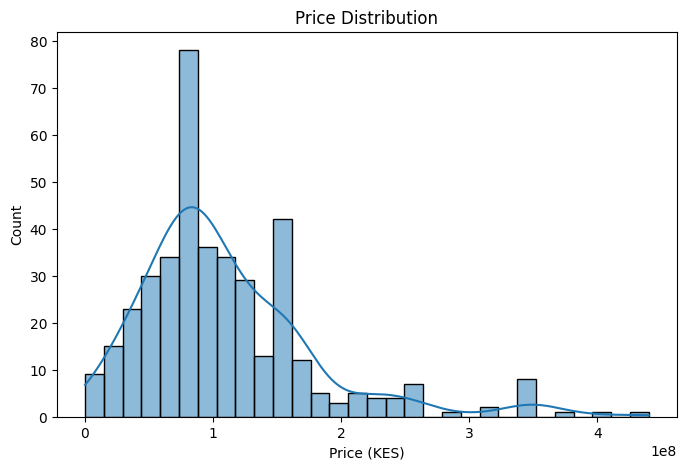

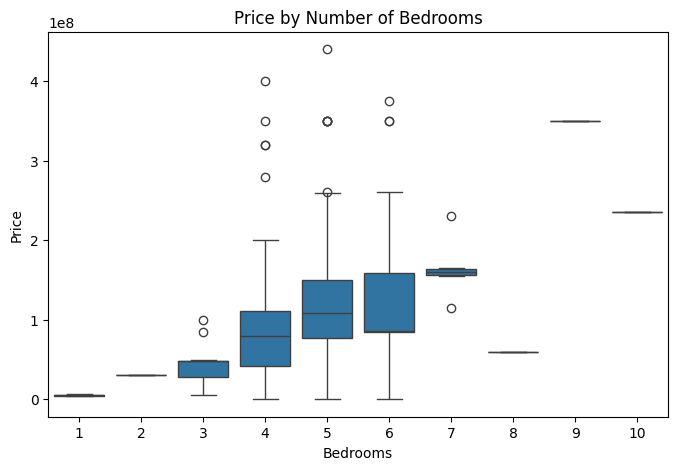

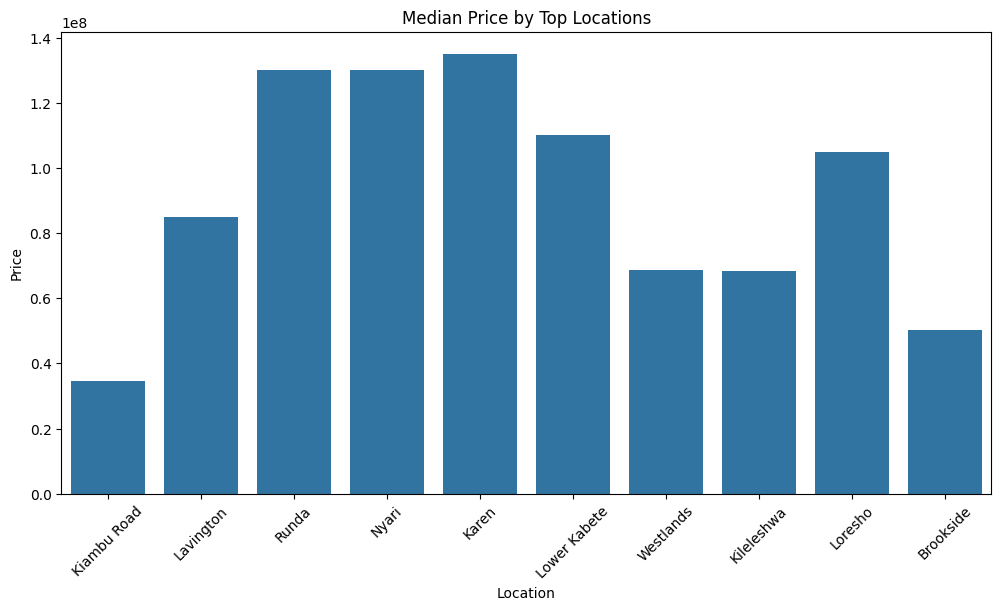

In [29]:
# Visual 1: Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], kde=True, bins=30)
plt.title('Price Distribution')
plt.xlabel('Price (KES)')
plt.ylabel('Count')
plt.savefig('../presentation/eda_price_hist.png')
plt.show()

# Visual 2: Price by Bedrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='Bedrooms', y='Price', data=df)
plt.title('Price by Number of Bedrooms')
plt.savefig('../presentation/eda_price_by_bedrooms.png')
plt.show()

# Visual 3: Median price by Location (top 10)
top_loc = df['Location'].value_counts().head(10).index
df_top = df[df['Location'].isin(top_loc)]
plt.figure(figsize=(12,6))
sns.barplot(x='Location', y='Price', data=df_top, estimator=np.median, errorbar=None)
plt.title('Median Price by Top Locations')
plt.xticks(rotation=45)
plt.savefig('../presentation/eda_median_price_location.png')
plt.show()